# [MNIST](https://en.wikipedia.org/wiki/MNIST_database) Digit Recognition Through Averages
stough 202-

In this notebook we'll define a simple linear scheme for recognizing hand-written digits. Every image we train on and ever test against is a $28\times28$ single-channel thumbnail. Look through [mnist_explore.ipynb](./mnist_explore.ipynb) for more. 

Our approach for recognizing the digit in a single image is simple: compare each pixel in the image against a template for each digit class. We'll do this through simple correlation: a dot-product of the image with the digit template. The higher the correlation, the higher the likelihood that the image is example of that template digit. 

In [1]:
%matplotlib inline
# or widget
import matplotlib.pyplot as plt

import numpy as np
from random import shuffle
import copy
import tempfile

from functools import partial
from multiprocessing.pool import ThreadPool

import torch

from torch.utils.data import (Dataset,
                              DataLoader)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# For importing from alternative directory sources
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import (arr_info,
                          make_linmap)

## Loading and Formatting the MNIST Data

In [2]:
# Thank you: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# https://pytorch.org/docs/stable/torchvision/datasets.html
mnist_trainset = datasets.MNIST(root='/home/dip365/data', train=True, download=False, transform=None)
mnist_testset = datasets.MNIST(root='/home/dip365/data', train=False, download=False, transform=None)

x_train = np.stack([np.array(x).ravel() for x,_ in mnist_trainset])
x_test = np.stack([np.array(x).ravel() for x,_ in mnist_testset])
y_train = np.stack([y for _,y in mnist_trainset]).astype('long')
y_test = np.stack([y for _,y in mnist_testset]).astype('long')

# These are Nx784
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

In [3]:
arr_info(x_train)

((60000, 784), dtype('float32'), 0.0, 1.0)

## 1. Vector-normalize the `x_train` and `x_test` data.
As you see above, each row of `x_train` (or `x_test`) is a $784$-dimensional vector. [Normalize](https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy-to-a-unit-vector) each row so that every image has a magnitude of $1$. We want to do this so that when we do correlations/[dot-products](https://en.wikipedia.org/wiki/Dot_product), the possible outcomes are all values in the range normalized range $[-1,1]$. Use [`norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) and [`divide`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.divide.html) to pretty easily perform this normalization.

In [4]:
norm = np.linalg.norm(x_test, ord=2, axis=-1, keepdims=True)
x_test = np.divide(x_test, norm)

norm = np.linalg.norm(x_train, ord=2, axis=-1, keepdims=True)
x_train = np.divide(x_train, norm)

In [5]:
## Check correctness, should be all True...
print(f'Is every row of x_test normalized?')
np.isclose(np.linalg.norm(x_test, axis=-1), 1.0)

Is every row of x_test normalized?


array([ True,  True,  True, ...,  True,  True,  True])

## 2. Compute a $10\times784$ matrix of template digits.
See [mnist_explore.ipynb](./mnist_explore.ipynb), where we compute the average seven for example. Do this for every digit using the `x_train` (and `y_train`) data. I call the resulting matrix `A` in the test cells.

In [6]:
A = np.zeros((10, x_train.shape[1]))  # =10x784
for i in range(10):
    samples = np.array([x_train[r] 
                       for r in range(len(x_train))
                       if y_train[r]==i])
    A[i] = np.sum(samples, axis=0)

In [7]:
norm = np.linalg.norm(A, ord=2, axis=-1, keepdims=True)
A = np.divide(A, norm)

In [8]:
## Test norm, should be all True...
np.isclose(np.linalg.norm(A, axis=-1), 1.0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

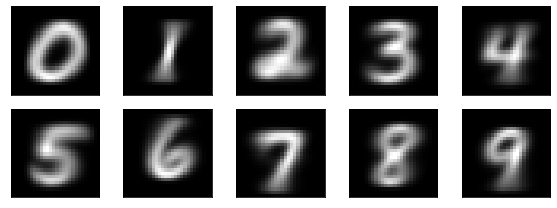

In [9]:
## Test sanity, visualize all the template digits
f, ax = plt.subplots(2,5, figsize=(8,3))
for i in range(5):
    ax[0, i].imshow(np.reshape(A[i,:], (28,28)), cmap='gray')
    ax[1, i].imshow(np.reshape(A[i+5,:], (28,28)), cmap='gray')

[a.axes.get_xaxis().set_visible(False) for a in ax.flatten()]
[a.axes.get_yaxis().set_visible(False) for a in ax.flatten()]
plt.tight_layout()

## 3. Correlate `x_test` against the template matrix.
Use [`matmul`](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) to compute the dot-product of every test case against every digit template. Given that there are 10K test images, our result should be $10000\times10$.

In [10]:
x_test.shape

(10000, 784)

In [11]:
A.shape

(10, 784)

In [12]:
x = np.matmul(x_test, A.T)

## 4. Compute the classification accuracy of this scheme.
Use [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to determine for each test case which template digit yielded the best score. Then compute the number that matched the correct labels from `y_test`. 

In [13]:
scores = np.argmax(x, axis=1)

In [14]:
arr_info(scores)

((10000,), dtype('int64'), 0, 9)

In [15]:
res = (scores==y_test).astype('int')  # where correct=1, wrong=0
np.sum(res)  # no. of correct = no. of 1s

8195

## 5. Show some examples of the incorrectly-classified digit images from `x_test`
Remember you can use [`where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to get the indices at which your `argmax` result above do not match the `y_test` labels.

In [16]:
wrongs = np.where(scores!=y_test)

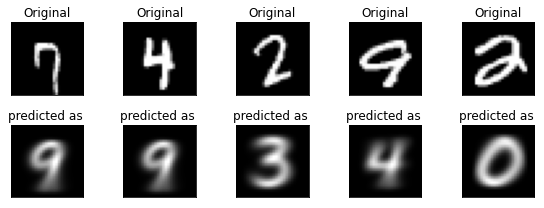

In [17]:
f, ax = plt.subplots(2,5, figsize=(8,3))

wrong_ex = np.random.choice(wrongs[0], 5)  # choose 5 wrong examples randomly

for i in range(5):
    ax[0, i].imshow(np.reshape(x_test[wrong_ex[i]], (28,28)), cmap='gray')     # original test pics
    ax[1, i].imshow(np.reshape(A[scores[wrong_ex[i]]], (28,28)), cmap='gray')  # wrong predictions illustrated 
                                                                               # by template digits
    ax[0, i].set_title('Original')
    ax[1, i].set_title('predicted as ')
    
[a.axes.get_xaxis().set_visible(False) for a in ax.flatten()]
[a.axes.get_yaxis().set_visible(False) for a in ax.flatten()]
plt.tight_layout()